In [1]:

import sys
gems_tco_path = "/Users/joonwonlee/GEMS_TCO/"
sys.path.append(gems_tco_path)

import copy
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim

In [2]:
lat_lon_resolution = [4,4]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]
# params= [20, 8.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= [0, 8]
analysis_data_map = {}
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(key_for_dict[0],key_for_dict[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:, :4].to_numpy()

aggregated_np = torch.from_numpy(aggregated_np).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


Now investigate empirical and theoretical semivariograms for latitude slices.

[10.205792427062988, 9.793783187866211, 9.46792984008789, 9.256928443908691, 9.183635711669922, 9.46792984008789, 10.205792427062988, 11.183155059814453, 12.24009895324707, 14.289220809936523, 15.659780502319336, 16.480735778808594, 17.576580047607422, 19.076854705810547, 21.1269588470459, 22.330055236816406, 23.031147003173828]
[14.800018310546875, 14.485992431640625, 14.187149047851562, 13.909171104431152, 13.658271789550781, 13.263608932495117, 13.051116943359375, 13.051116943359375, 13.263608932495117, 14.187149047851562, 15.124200820922852, 15.786423683166504, 16.768959045410156, 18.26416778564453, 20.522037506103516, 21.93698501586914, 22.788131713867188]
[17.868976593017578, 17.65208625793457, 17.438091278076172, 17.228782653808594, 17.026153564453125, 16.649761199951172, 16.327756881713867, 16.079540252685547, 15.92243766784668, 15.92243766784668, 16.193256378173828, 16.480735778808594, 17.026153564453125, 18.087158203125, 20.114952087402344, 21.594036102294922, 22.549650192260

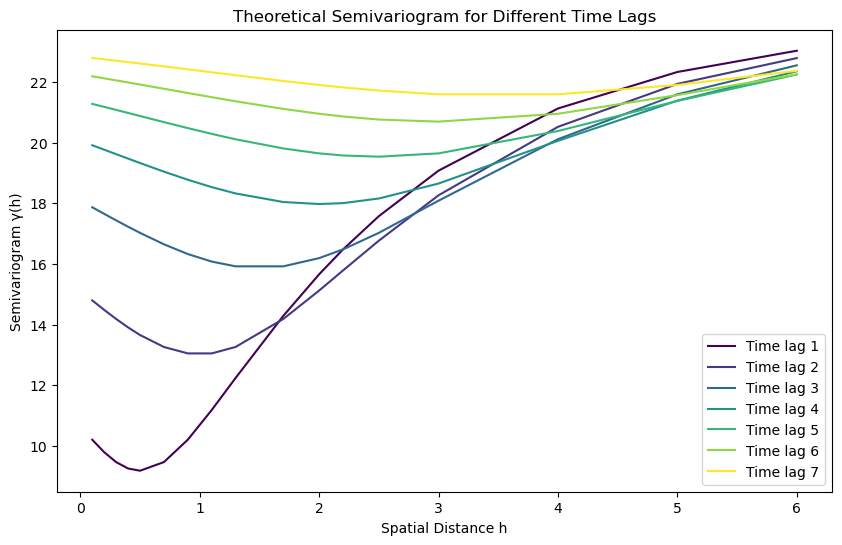

In [ ]:
def theoretical_gamma(params, lat_diff, lon_diff, time_diff):
    # Unpack parameters
    sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
    
    # Calculate the spatial-temporal differences
    tmp1 = lat_diff - advec_lat * time_diff
    tmp2 = lon_diff - advec_lon * time_diff
    tmp3 = beta * time_diff
    
  
    d = tmp1**2/range_lat + tmp2**2/range_lon + tmp3**2
    
    # Convert d into a tensor (if it's not already) and compute the semivariogram
    d = d.clone().detach()

    out = nugget + sigmasq * (1 - torch.exp(- torch.sqrt(d) ) )
    
    return torch.sqrt(d), out

# Example parameters (sigmasq, range, range_lon, advec, beta, nugget)
params = [20, 10, 5, 0.5, 0.5, 0.3, 4]

# Function to compute theoretical semivariogram for each delta and time lag
def plot_theoretical_semivariogram(params, deltas, time_lags):
    # Create a plot with different colors for each time difference
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_lags)))  # Color map for different time lags
    
    for t in range(len(time_lags)):
        gamma_values = []
        d_values = []
        for delta in deltas:
            # Calculate theoretical semivariogram for this distance and time lag
            d, gamma = theoretical_gamma(params, delta, delta, time_lags[t])  # lat_diff = lon_diff = delta, time_diff = t
            
            gamma_values.append(gamma.item())  # Convert tensor to scalar for plotting
            d_values.append(d.item())
        print(gamma_values)
        # Plot the semivariogram for the current time lag
        plt.plot(deltas, gamma_values, label=f"Time lag {time_lags[t]}", color=colors[t])
        # plot depends on d_values or deltas

        
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel("Spatial Distance h")
    plt.ylabel("Semivariogram γ(h)")
    plt.title("Theoretical Semivariogram for Different Time Lags")
    plt.legend()
    plt.show()

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0, 5.0, 6.0])

# Define the time lags you want to plot
time_lags = [1, 2, 3, 4, 5, 6, 7]

# Plot the theoretical semivariogram for the specified time lags
plot_theoretical_semivariogram(params, deltas, time_lags)




empirical semivariogram

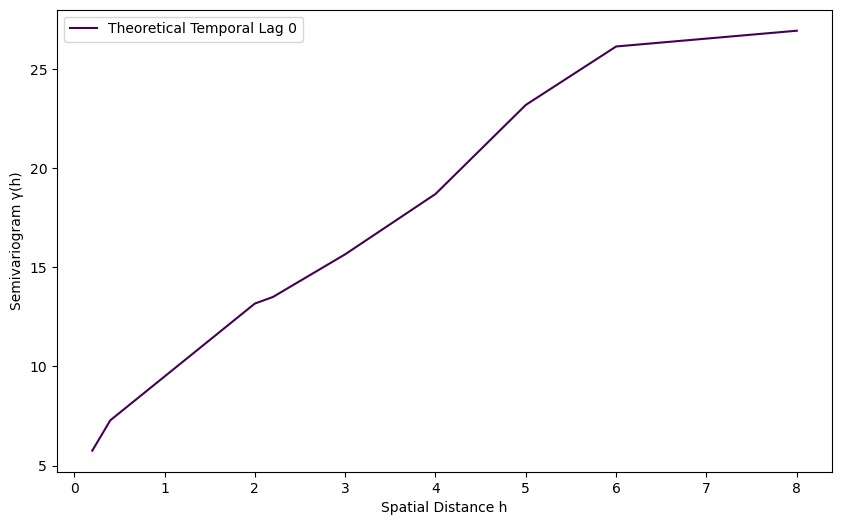

tensor([ 5.7463,  7.2819, 13.1734, 13.5056, 15.6596, 18.7042, 23.2002, 26.1495,
        26.9445])

In [18]:
tolerance = 0.02
def theoretical_semivariogram(params, data, deltas ,tolerance, latitude_lag,temporal_lag):
    # Extract data columns: latitude, longitude, time, values
    lat = data[:, 0]
    lon = data[:, 1]
    time = data[:, 3]
    values = data[:, 2]  # Assuming the values are in the 3rd column

    # Calculate spatial and temporal distances
    lat_distances = lat.unsqueeze(1) - lat.unsqueeze(0)
    lon_distances = lon.unsqueeze(1) - lon.unsqueeze(0)
    temporal_distances = torch.abs(time.unsqueeze(1) - time.unsqueeze(0))
    
    
    theoretical_gamma = torch.zeros(len(deltas))
    
    
    # Calculate the semivariogram for each delta value
    for i in range(len(deltas)):
        # Mask for spatial distances within the delta range and specific temporal lag
        mask = (torch.abs(lat_distances - latitude_lag) <= tolerance) & \
               (torch.abs(lon_distances - deltas[i]) <= tolerance) & \
               (temporal_distances == temporal_lag)
        if torch.any(mask):
            # Calculate semivariogram using squared differences of values
            differences = torch.abs(values.unsqueeze(1) - values.unsqueeze(0))
            theoretical_gamma[i] = 0.5 * torch.mean(differences[mask]**2)

    # Calculate the sill (variance of the values within the given temporal lag)

    
    # Create bins (spatial distances) from the deltas (you can adjust as needed)

    return deltas, theoretical_gamma

# Define deltas for distance bins
deltas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.7, 2.0, 2.2, 2.5, 3.0, 4.0,5,6,8, 10, 12])

colors = plt.cm.viridis(np.linspace(0, 1, 8))  # Color map for the temporal lags

data = aggregated_np
# Plot the empirical and theoretical semivariogram for different temporal lags
plt.figure(figsize=(10, 6))

latitude_lag = 0.2

for temporal_lag in range(1): 
    deltas, theoretical_gamma = theoretical_semivariogram(params, data, deltas,tolerance, latitude_lag,  temporal_lag)
    mask = theoretical_gamma!=0
    deltas = deltas[mask]
    theoretical_gamma = theoretical_gamma[mask]
    
    plt.plot( deltas.clone().detach(), theoretical_gamma.clone().detach(), color=colors[temporal_lag], label=f'Theoretical Temporal Lag {temporal_lag}')

plt.xlabel('Spatial Distance h')
plt.ylabel('Semivariogram γ(h)')
plt.legend()
plt.show()

theoretical_gamma